In [1]:
import pandas as pd
import numpy as np
import json
import seaborn as sns
import matplotlib.pyplot as plt
import mlflow
import mlflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, InputLayer, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [2]:
# Load Air Quality data
with open('../data/air_quality/historical/air_quality_historical.json') as f:
    air_quality_data = json.load(f)

# Load Weather data
with open('../data/weather/historical/weather_historical.json') as f:
    weather_data = json.load(f)

# Convert the data to DataFrames
air_quality_df = pd.json_normalize(air_quality_data['list'])
# Convert the Weather data to DataFrame with 'datetime' and 'datetimeEpoch' distinguished
weather_df = pd.json_normalize(
    weather_data['days'], 'hours', 
    ['datetime', 'datetimeEpoch'], 
    meta_prefix='weather_'
)

# Convert 'datetimeEpoch' to datetime for merging purposes
air_quality_df['datetime'] = pd.to_datetime(air_quality_df['dt'], unit='s')
weather_df['datetime'] = pd.to_datetime(weather_df['datetimeEpoch'], unit='s')


In [3]:
# Merge the weather and air quality data on datetime
merged_df = pd.merge(weather_df[['datetime', 'temp', 'dew', 'humidity', 'windgust', 'windspeed', 'winddir', 'pressure', 'cloudcover', 
                                'visibility', 'solarradiation', 'solarenergy', 'uvindex']],
                     air_quality_df[['datetime', 'components.so2', 'components.no2', 'components.pm10', 'components.pm2_5', 'components.o3', 'components.co']],
                     on='datetime', how='inner')

# Check the merged data
merged_df.head()

,datetime,temp,dew,humidity,windgust,windspeed,winddir,pressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,components.so2,components.no2,components.pm10,components.pm2_5,components.o3,components.co
0,2024-11-01 00:00:00,13.6,9.0,73.83,14.8,1.6,360.0,1012.8,0.0,3.0,0.0,0.0,0.0,2.86,19.54,64.04,47.04,30.76,907.90
1,2024-11-01 01:00:00,15.7,13.7,87.90,14.8,8.3,16.8,1012.0,70.0,24.1,0.0,0.0,0.0,3.07,20.39,59.64,42.60,26.11,881.20
2,2024-11-01 02:00:00,16.0,13.2,83.46,15.5,7.2,19.4,1012.0,95.9,24.1,11.1,0.0,0.0,3.67,30.50,63.07,43.20,11.09,1054.76
3,2024-11-01 03:00:00,16.7,10.2,65.31,15.8,6.0,36.0,1013.6,60.0,6.5,186.0,0.7,2.0,4.47,33.59,73.83,49.66,7.78,1482.01
4,2024-11-01 04:00:00,20.1,11.7,58.45,16.6,6.1,351.0,1014.0,95.7,24.1,334.1,1.2,3.0,5.07,36.33,85.08,57.72,14.13,1869.20


In [4]:
# merged_df.to_csv('merged_data.csv', index=False)

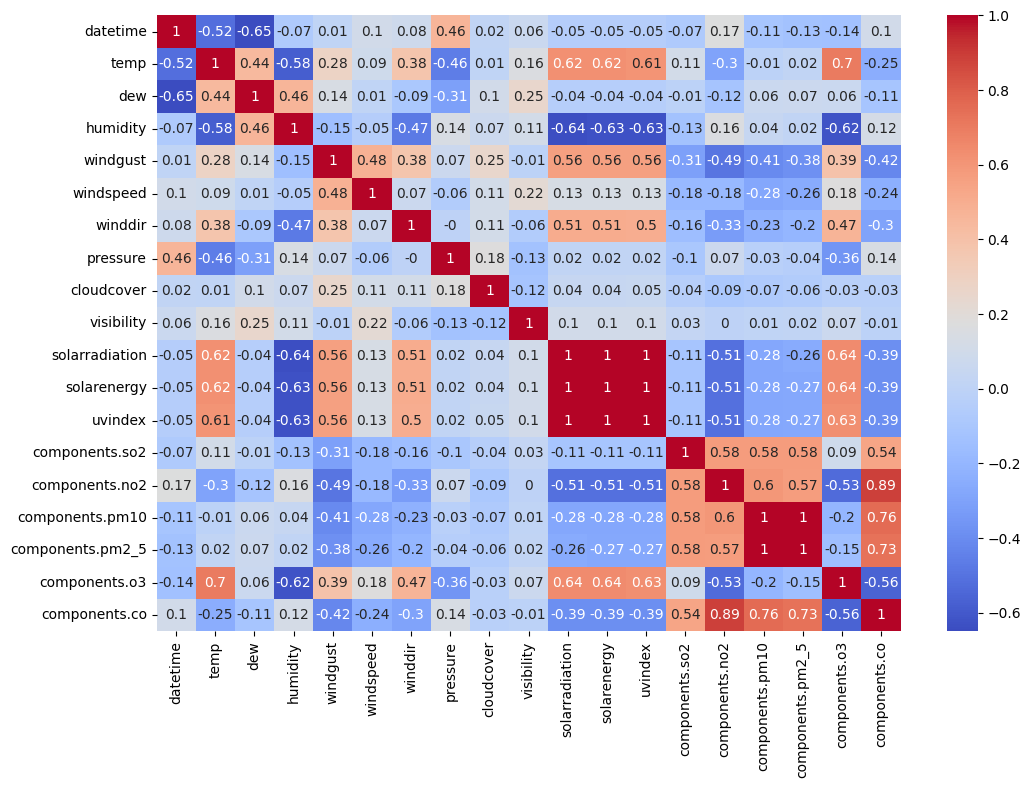

In [5]:
# create a pearson correlation matrix (heatmap) of the merged data
correlation_matrix = merged_df.corr(method='pearson')
# Round the values to 2 decimal places
correlation_matrix = correlation_matrix.round(2)

# Making a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()


In [6]:
# Check for missing values
if merged_df.isnull().sum().sum() == 0:
    print('No missing values in the merged data')


No missing values in the merged data


In [7]:
merged_df.shape

(721, 19)

In [8]:
FEATURES = ['temp', 'dew', 'humidity', 'windspeed', 'windgust', 'winddir', 'pressure', 'solarenergy']

TARGETS = ['components.so2', 'components.no2', 'components.pm10', 'components.pm2_5', 'components.o3', 'components.co']

In [9]:
# Remove the outliers
merged_df = merged_df[(np.abs(merged_df[FEATURES] - merged_df[FEATURES].mean()) / merged_df[FEATURES].std() <= 3).all(axis=1)]
merged_df = merged_df[(np.abs(merged_df[TARGETS] - merged_df[TARGETS].mean()) / merged_df[TARGETS].std() <= 3).all(axis=1)]

In [10]:
merged_df.shape

(673, 19)

In [11]:
def create_sequences(df, seq_length, features, targets):
    """
    Create sequences of data for LSTM.

    :param df: DataFrame containing the data
    :param seq_length: Number of past time steps to include in each sequence
    :param features: List of feature column names
    :param targets: List of target column names
    :return: Tuple of numpy arrays (X, y)
    """
    X = []
    y = []
    
    for i in range(len(df) - seq_length):
        X_seq = df[features].iloc[i:i+seq_length].values
        y_seq = df[targets].iloc[i+seq_length].values
        X.append(X_seq)
        y.append(y_seq)
    
    return np.array(X), np.array(y)

In [12]:
SEQ_LENGTH = 24  # Using past 24 hours

# Create sequences
#X, y = create_sequences(merged_df_lagged, SEQ_LENGTH, FEATURES_LAGGED, TARGETS)
X, y = create_sequences(merged_df, SEQ_LENGTH, FEATURES, TARGETS)

print(f'X shape: {X.shape}')  # Expected: (num_samples, 24, 10)
print(f'y shape: {y.shape}')  # Expected: (num_samples, 6)

X shape: (649, 24, 8)
y shape: (649, 6)


In [13]:
import os
# Create models directory if it doesn't exist
os.makedirs('../models/', exist_ok=True)


In [14]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import joblib  # For saving scalers

# Initialize separate scalers
feature_scaler = StandardScaler()
target_scaler = StandardScaler()

# Fit and transform features
X_scaled = feature_scaler.fit_transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)

# Fit and transform targets
y_scaled = target_scaler.fit_transform(y)

# Save the scalers for future use
joblib.dump(feature_scaler, '../models/feature_scaler.joblib')
joblib.dump(target_scaler, '../models/target_scaler.joblib')


['../models/target_scaler.joblib']

In [15]:
# Define split ratio
TRAIN_RATIO = 0.8
num_train = int(len(X) * TRAIN_RATIO)

X_train = X_scaled[:num_train]
y_train = y_scaled[:num_train]
X_test = X_scaled[num_train:]
y_test = y_scaled[num_train:]

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')


X_train shape: (519, 24, 8)
y_train shape: (519, 6)
X_test shape: (130, 24, 8)
y_test shape: (130, 6)


In [16]:
from tensorflow.keras.optimizers import Adam

def build_lstm_model(input_shape, output_size):
    """
    Build and compile an LSTM model.

    :param input_shape: Shape of the input data (timesteps, features)
    :param output_size: Number of target variables
    :return: Compiled Keras model
    """
    model = Sequential()
    
    # Define the input layer explicitly using the 'shape' argument instead of 'input_shape'
    model.add(InputLayer(shape=input_shape))

    # Add LSTM layers
    model.add(LSTM(128, activation='tanh', return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(128, activation='tanh', return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(128, activation='tanh'))
    model.add(Dropout(0.2))
    
    # Add output layer
    model.add(Dense(output_size, activation='linear'))  # Linear activation for regression
    
    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    
    return model

# Get input shape
input_shape = (X_train.shape[1], X_train.shape[2])  # (24, 10)
output_size = y_train.shape[1]  # 6

# Build the model
model = build_lstm_model(input_shape, output_size)

# Summarize the model
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24, 128)        │        70,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 24, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 24, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 334,086 (1.27 MB)

 Trainable params: 334,086 (1.27 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# Set MLflow experiment name outside of this folder
mlflow.set_experiment("Pollution_Trend_Prediction_LSTM")


2024/12/13 00:59:48 INFO mlflow.tracking.fluent: Experiment with name 'Pollution_Trend_Prediction_LSTM' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///d:/Semester%207/ML-Ops/course-project-anas-farooq8/src/mlruns/941701741260826522', creation_time=1734033588379, experiment_id='941701741260826522', last_update_time=1734033588379, lifecycle_stage='active', name='Pollution_Trend_Prediction_LSTM', tags={}>

In [18]:
# Define callbacks
early_stop = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=3, verbose=1)

In [19]:
with mlflow.start_run():
    # Log model parameters
    mlflow.log_param("sequence_length", SEQ_LENGTH)
    mlflow.log_param("features", FEATURES)
    mlflow.log_param("targets", TARGETS)
    mlflow.log_param("batch_size", 32)
    mlflow.log_param("epochs", 100)
    mlflow.log_param("learning_rate", 0.001)
    mlflow.log_param("optimizer", "Adam")
    mlflow.log_param("loss_function", "mse")
    mlflow.log_param("metrics", ["mae"])
    mlflow.log_param("dropout", 0.2)
    mlflow.log_param("units", 64)
    
    # Train the model
    history = model.fit(
        X_train, y_train,
        epochs=50,
        batch_size=32,
        #validation_split=0.2,
        callbacks=[early_stop, reduce_lr],
        verbose=1
    )
    
    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Initialize lists to store evaluation metrics
    mse_list = []
    mae_list = []
    
    # Calculate evaluation metrics for each target on the original scale
    for i in range(y_test.shape[1]):
        mse = mean_squared_error(y_test[:, i], y_pred[:, i])
        mae = mean_absolute_error(y_test[:, i], y_pred[:, i])
        mse_list.append(mse)
        mae_list.append(mae)
        print(f"Pollutant {TARGETS[i]} - MSE: {mse:.4f}, MAE: {mae:.4f}")
        
        # Log metrics to MLflow
        mlflow.log_metric(f"MSE_{TARGETS[i]}", mse)
        mlflow.log_metric(f"MAE_{TARGETS[i]}", mae)


    # Calculate and log average metrics
    average_mse = np.mean(mse_list)
    average_mae = np.mean(mae_list)
    mlflow.log_metric("Average_MSE", average_mse)
    mlflow.log_metric("Average_MAE", average_mae)
    
    print(f"Average MSE: {average_mse:.4f}, Average MAE: {average_mae:.4f}")
    
    # Log the model
    mlflow.keras.log_model(model, "model")
    
    # Save the model
    # model.save("../models/lstm_pollution_model.keras")


Epoch 1/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - loss: 0.8404 - mae: 0.7302 - learning_rate: 0.0010
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.5723 - mae: 0.5802 - learning_rate: 0.0010
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.4822 - mae: 0.5227 - learning_rate: 0.0010
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.4236 - mae: 0.4796 - learning_rate: 0.0010
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.3449 - mae: 0.4342 - learning_rate: 0.0010
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.3271 - mae: 0.4139 - learning_rate: 0.0010
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.2896 - mae: 0.3714 - learning_rate: 0.0010
Epoch 8/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.2130 - mae: 0.3296 - learning_rate: 0.0010
Epoch 9/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.1820 - mae: 0.3058 - learning_rate: 0.0010
Epoch 10/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.15

2024/12/13 01:00:35 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Pollutant components.so2 - MSE: 0.6590, MAE: 0.5915
Pollutant components.no2 - MSE: 0.2495, MAE: 0.3710
Pollutant components.pm10 - MSE: 0.5254, MAE: 0.5874
Pollutant components.pm2_5 - MSE: 0.5787, MAE: 0.6217
Pollutant components.o3 - MSE: 0.2146, MAE: 0.3332
Pollutant components.co - MSE: 0.4835, MAE: 0.5548
Average MSE: 0.4518, Average MAE: 0.5099


2024/12/13 01:00:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


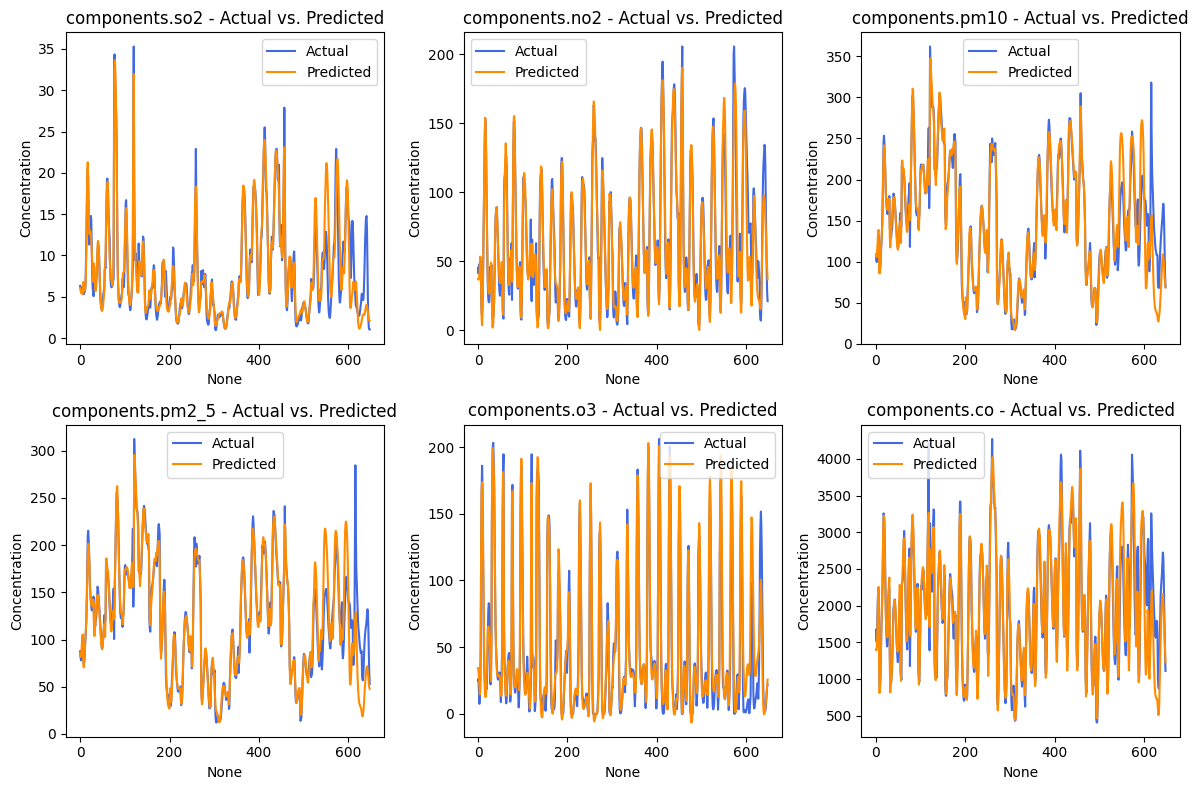

In [20]:
# Test the model using visualization
# Inverse transform the scaled data
y_scaled_inv = target_scaler.inverse_transform(y_scaled)
# Make predictions on the scaled data
y_pred_scaled = model.predict(X_scaled)
y_pred_scaled_inv = target_scaler.inverse_transform(y_pred_scaled)

# Create a DataFrame for the actual and predicted values
results_dict = {f'{target}_actual': y_scaled_inv[:, i] for i, target in enumerate(TARGETS)}
results_dict.update({f'{target}_predicted': y_pred_scaled_inv[:, i] for i, target in enumerate(TARGETS)})
results_df = pd.DataFrame(results_dict)

# Plot the actual and predicted values
plt.figure(figsize=(12, 8))
for i, target in enumerate(TARGETS):
    plt.subplot(2, 3, i+1)
    sns.lineplot(x=results_df.index, y=f'{target}_actual', data=results_df, label='Actual', color='royalblue')
    sns.lineplot(x=results_df.index, y=f'{target}_predicted', data=results_df, label='Predicted', color='darkorange')
    plt.title(f'{target} - Actual vs. Predicted')
    plt.ylabel('Concentration')
    plt.legend()
plt.tight_layout()
plt.show()


In [21]:
# print r2 score of each target
from sklearn.metrics import r2_score

r2_scores = []
for i, target in enumerate(TARGETS):
    r2 = r2_score(y_scaled_inv[:, i], y_pred_scaled_inv[:, i])
    r2_scores.append(r2)
    print(f"R2 score for {target}: {r2:.4f}")
    

R2 score for components.so2: 0.8423
R2 score for components.no2: 0.9361
R2 score for components.pm10: 0.8828
R2 score for components.pm2_5: 0.8710
R2 score for components.o3: 0.9386
R2 score for components.co: 0.8794


In [22]:
mlflow.end_run()

In [23]:
import pandas as pd
import numpy as np
import json
import seaborn as sns
import matplotlib.pyplot as plt
import mlflow
import mlflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, InputLayer, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [24]:
# Import necessary libraries
from itertools import product

# Define hyperparameter grid
hyperparameter_grid = {
    'units': [128],
    'dropout': [0.2, 0.3],
    'learning_rate': [0.001, 0.0001],
    'batch_size': [16, 32],
    'epochs': [50]
}

# Create all combinations of hyperparameters
keys, values = zip(*hyperparameter_grid.items())
hyperparameter_combinations = [dict(zip(keys, v)) for v in product(*values)]

print(f"Total hyperparameter combinations to try: {len(hyperparameter_combinations)}")

# Iterate over each combination
for idx, params in enumerate(hyperparameter_combinations):
    print(f"\nTraining model {idx + 1}/{len(hyperparameter_combinations)} with parameters: {params}")
    
    with mlflow.start_run(run_name=f"Run_{idx + 1}"):
        # Log hyperparameters
        mlflow.log_params(params)
        mlflow.log_param("sequence_length", SEQ_LENGTH)
        mlflow.log_param("features", FEATURES)
        mlflow.log_param("targets", TARGETS)
        mlflow.log_param("batch_size", params['batch_size'])
        mlflow.log_param("epochs", params['epochs'])
        mlflow.log_param("learning_rate", params['learning_rate'])
        mlflow.log_param("optimizer", "Adam")
        mlflow.log_param("loss_function", "mse")
        mlflow.log_param("metrics", ["mae"])
        mlflow.log_param("dropout", params['dropout'])
        mlflow.log_param("units", params['units'])
        
        # Build the model with current hyperparameters
        model = Sequential()
        input_shape = (X_train.shape[1], X_train.shape[2])  # (24, 10)

        model.add(InputLayer(shape=(input_shape)))
        model.add(LSTM(
            units=params['units'],
            activation='tanh',
            return_sequences=True
        ))
        model.add(Dropout(rate=params['dropout']))
        model.add(LSTM(
            units=params['units'],
            activation='tanh',
            return_sequences=True
        ))
        model.add(Dropout(rate=params['dropout']))
        model.add(LSTM(
            units=params['units'],
            activation='tanh'
        ))
        model.add(Dropout(rate=params['dropout']))
        model.add(Dense(len(TARGETS), activation='linear'))
        
        # Compile the model
        optimizer = Adam(learning_rate=params['learning_rate'])
        model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
        
        # Define callbacks
        early_stop = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
        reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=3, verbose=1)
        
        # Train the model
        history = model.fit(
            X_train, y_train,
            epochs=params['epochs'],
            batch_size=params['batch_size'],
            callbacks=[early_stop, reduce_lr],
            verbose=1
        )
        
        # Make predictions on the test set
        y_pred = model.predict(X_test)
        
        # Calculate evaluation metrics for each target
        mse_list = []
        mae_list = []
        
        for i in range(y_test.shape[1]):
            mse = mean_squared_error(y_test[:, i], y_pred[:, i])
            mae = mean_absolute_error(y_test[:, i], y_pred[:, i])
            mse_list.append(mse)
            mae_list.append(mae)
            print(f"Pollutant {TARGETS[i]} - MSE: {mse:.4f}, MAE: {mae:.4f}")
            
            # Log metrics to MLflow
            mlflow.log_metric(f"MSE_{TARGETS[i]}", mse)
            mlflow.log_metric(f"MAE_{TARGETS[i]}", mae)
        
        # Calculate and log average metrics
        average_mse = np.mean(mse_list)
        average_mae = np.mean(mae_list)
        mlflow.log_metric("Average_MSE", average_mse)
        mlflow.log_metric("Average_MAE", average_mae)
        
        print(f"Average MSE: {average_mse:.4f}, Average MAE: {average_mae:.4f}")
        
        # Log the model
        mlflow.keras.log_model(model, "model")


Total hyperparameter combinations to try: 8

Training model 1/8 with parameters: {'units': 128, 'dropout': 0.2, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 50}
Epoch 1/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - loss: 0.7828 - mae: 0.6979 - learning_rate: 0.0010
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.5377 - mae: 0.5581 - learning_rate: 0.0010
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.4319 - mae: 0.4939 - learning_rate: 0.0010
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.3446 - mae: 0.4428 - learning_rate: 0.0010
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.2969 - mae: 0.4018 - learning_rate: 0.0010
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 0.2558 - mae: 0.3666 - learning_rate: 0.0010
Epoch 7/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 0.1918 - mae: 0.3171 - learning_rate: 0.0010
Epoch 8/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 0.1815 - mae: 0.3185 - learning_rate: 0.0010


2024/12/13 01:01:51 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Pollutant components.so2 - MSE: 0.6609, MAE: 0.6047
Pollutant components.no2 - MSE: 0.2462, MAE: 0.3705
Pollutant components.pm10 - MSE: 0.4896, MAE: 0.5830
Pollutant components.pm2_5 - MSE: 0.5586, MAE: 0.6285
Pollutant components.o3 - MSE: 0.2354, MAE: 0.3628
Pollutant components.co - MSE: 0.4368, MAE: 0.5386
Average MSE: 0.4379, Average MAE: 0.5147


2024/12/13 01:01:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Training model 2/8 with parameters: {'units': 128, 'dropout': 0.2, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 50}
Epoch 1/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - loss: 0.9374 - mae: 0.7676 - learning_rate: 0.0010
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.5214 - mae: 0.5521 - learning_rate: 0.0010
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.5108 - mae: 0.5446 - learning_rate: 0.0010
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.4399 - mae: 0.4920 - learning_rate: 0.0010
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.3889 - mae: 0.4631 - learning_rate: 0.0010
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.3241 - mae: 0.4184 - learning_rate: 0.0010
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.2984 - mae: 0.3962 - learning_rate: 0.0010
Epoch 8/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.2615 - mae: 0.3757 - learning_rate: 0.0010
Epoch 9/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 60m

2024/12/13 01:02:53 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Pollutant components.so2 - MSE: 0.7011, MAE: 0.6141
Pollutant components.no2 - MSE: 0.2879, MAE: 0.4120
Pollutant components.pm10 - MSE: 0.7094, MAE: 0.6501
Pollutant components.pm2_5 - MSE: 0.7972, MAE: 0.6921
Pollutant components.o3 - MSE: 0.2137, MAE: 0.3355
Pollutant components.co - MSE: 0.6840, MAE: 0.6605
Average MSE: 0.5655, Average MAE: 0.5607


2024/12/13 01:03:00 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Training model 3/8 with parameters: {'units': 128, 'dropout': 0.2, 'learning_rate': 0.0001, 'batch_size': 16, 'epochs': 50}
Epoch 1/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - loss: 1.0564 - mae: 0.8364 - learning_rate: 1.0000e-04
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.8368 - mae: 0.7227 - learning_rate: 1.0000e-04
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 0.7017 - mae: 0.6515 - learning_rate: 1.0000e-04
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.6012 - mae: 0.6033 - learning_rate: 1.0000e-04
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.5462 - mae: 0.5610 - learning_rate: 1.0000e-04
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.5121 - mae: 0.5420 - learning_rate: 1.0000e-04
Epoch 7/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.5012 - mae: 0.5291 - learning_rate: 1.0000e-04
Epoch 8/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.4381 - mae: 0.4992 - learning_rate: 1.0000e-04
Epoch 9/50


2024/12/13 01:04:30 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Pollutant components.so2 - MSE: 0.6036, MAE: 0.5575
Pollutant components.no2 - MSE: 0.3079, MAE: 0.4480
Pollutant components.pm10 - MSE: 0.5811, MAE: 0.5821
Pollutant components.pm2_5 - MSE: 0.6591, MAE: 0.6267
Pollutant components.o3 - MSE: 0.2444, MAE: 0.3577
Pollutant components.co - MSE: 0.6926, MAE: 0.6705
Average MSE: 0.5148, Average MAE: 0.5404


2024/12/13 01:04:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Training model 4/8 with parameters: {'units': 128, 'dropout': 0.2, 'learning_rate': 0.0001, 'batch_size': 32, 'epochs': 50}
Epoch 1/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - loss: 1.0511 - mae: 0.8301 - learning_rate: 1.0000e-04
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.9626 - mae: 0.7922 - learning_rate: 1.0000e-04
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.8260 - mae: 0.7271 - learning_rate: 1.0000e-04
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.8127 - mae: 0.7115 - learning_rate: 1.0000e-04
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.7334 - mae: 0.6598 - learning_rate: 1.0000e-04
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.6230 - mae: 0.6126 - learning_rate: 1.0000e-04
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.5841 - mae: 0.5912 - learning_rate: 1.0000e-04
Epoch 8/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.5832 - mae: 0.5853 - learning_rate: 1.0000e-04
Epoch 9/50


2024/12/13 01:05:33 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Pollutant components.so2 - MSE: 0.8699, MAE: 0.6909
Pollutant components.no2 - MSE: 0.4179, MAE: 0.5014
Pollutant components.pm10 - MSE: 0.6725, MAE: 0.6424
Pollutant components.pm2_5 - MSE: 0.7444, MAE: 0.6802
Pollutant components.o3 - MSE: 0.2814, MAE: 0.3854
Pollutant components.co - MSE: 0.6354, MAE: 0.6503
Average MSE: 0.6036, Average MAE: 0.5918


2024/12/13 01:05:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Training model 5/8 with parameters: {'units': 128, 'dropout': 0.3, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 50}
Epoch 1/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - loss: 0.8435 - mae: 0.7237 - learning_rate: 0.0010
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.5203 - mae: 0.5494 - learning_rate: 0.0010
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - loss: 0.4024 - mae: 0.4716 - learning_rate: 0.0010
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - loss: 0.3776 - mae: 0.4553 - learning_rate: 0.0010
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - loss: 0.3002 - mae: 0.3998 - learning_rate: 0.0010
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - loss: 0.2408 - mae: 0.3694 - learning_rate: 0.0010
Epoch 7/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - loss: 0.2199 - mae: 0.3443 - learning_rate: 0.0010
Epoch 8/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - loss: 0.2055 - mae: 0.3259 - learning_rate: 0.0010
Epoch 9/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 8

2024/12/13 01:08:06 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/12/13 01:08:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Training model 6/8 with parameters: {'units': 128, 'dropout': 0.3, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 50}
Epoch 1/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 15s 98ms/step - loss: 0.8939 - mae: 0.7605 - learning_rate: 0.0010
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 0.5787 - mae: 0.5932 - learning_rate: 0.0010
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.4838 - mae: 0.5367 - learning_rate: 0.0010
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 0.4099 - mae: 0.4787 - learning_rate: 0.0010
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 0.4409 - mae: 0.5026 - learning_rate: 0.0010
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - loss: 0.3353 - mae: 0.4271 - learning_rate: 0.0010
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - loss: 0.3181 - mae: 0.4110 - learning_rate: 0.0010
Epoch 8/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - loss: 0.2464 - mae: 0.3689 - learning_rate: 0.0010
Epoch 9/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 86

2024/12/13 01:10:12 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Average MSE: 0.4763, Average MAE: 0.5334


2024/12/13 01:10:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Training model 7/8 with parameters: {'units': 128, 'dropout': 0.3, 'learning_rate': 0.0001, 'batch_size': 16, 'epochs': 50}
Epoch 1/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 14s 72ms/step - loss: 1.0400 - mae: 0.8302 - learning_rate: 1.0000e-04
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - loss: 0.8767 - mae: 0.7546 - learning_rate: 1.0000e-04
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 0.7219 - mae: 0.6626 - learning_rate: 1.0000e-04
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 0.6274 - mae: 0.6125 - learning_rate: 1.0000e-04
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - loss: 0.5564 - mae: 0.5787 - learning_rate: 1.0000e-04
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss: 0.5074 - mae: 0.5426 - learning_rate: 1.0000e-04
Epoch 7/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 0.4686 - mae: 0.5224 - learning_rate: 1.0000e-04
Epoch 8/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - loss: 0.4755 - mae: 0.5147 - learning_rate: 1.0000e-04
Epoch 9/50

2024/12/13 01:13:03 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Average MSE: 0.5163, Average MAE: 0.5696


2024/12/13 01:13:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Training model 8/8 with parameters: {'units': 128, 'dropout': 0.3, 'learning_rate': 0.0001, 'batch_size': 32, 'epochs': 50}
Epoch 1/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 84ms/step - loss: 1.0270 - mae: 0.8147 - learning_rate: 1.0000e-04
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - loss: 0.9244 - mae: 0.7718 - learning_rate: 1.0000e-04
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - loss: 0.9031 - mae: 0.7622 - learning_rate: 1.0000e-04
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - loss: 0.7533 - mae: 0.6856 - learning_rate: 1.0000e-04
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - loss: 0.6873 - mae: 0.6387 - learning_rate: 1.0000e-04
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - loss: 0.6255 - mae: 0.6153 - learning_rate: 1.0000e-04
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - loss: 0.5841 - mae: 0.5899 - learning_rate: 1.0000e-04
Epoch 8/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.5874 - mae: 0.5907 - learning_rate: 1.0000e-04
Epoch 9/

2024/12/13 01:15:06 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Average MSE: 0.5736, Average MAE: 0.5940


2024/12/13 01:15:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [25]:
import mlflow.keras
from tensorflow.keras.models import load_model

# Replace <BEST_RUN_ID> with the actual Run ID of the best run
best_run_id = "a26f7d91371e40b0a5471558a2cc4a6b"
model_uri = f"runs:/{best_run_id}/model"

# Load the model from MLflow
best_model = mlflow.keras.load_model(model_uri)


In [26]:
best_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 24, 128)        │        70,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 24, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 24, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 24, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,002,260 (3.82 MB)

 Trainable params: 334,086 (1.27 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 668,174 (2.55 MB)

In [27]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Make predictions using the best model
y_pred_best = best_model.predict(X_test)

# Calculate evaluation metrics for each target
mse_list_best = []
mae_list_best = []

for i in range(y_test.shape[1]):
    mse = mean_squared_error(y_test[:, i], y_pred_best[:, i])
    mae = mean_absolute_error(y_test[:, i], y_pred_best[:, i])
    mse_list_best.append(mse)
    mae_list_best.append(mae)
    print(f"Best Model - Pollutant {TARGETS[i]} - MSE: {mse:.4f}, MAE: {mae:.4f}")

# Calculate and print average metrics
average_mse_best = np.mean(mse_list_best)
average_mae_best = np.mean(mae_list_best)

print(f"Best Model - Average MSE: {average_mse_best:.4f}, Average MAE: {average_mae_best:.4f}")


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 331ms/step
Best Model - Pollutant components.so2 - MSE: 0.6609, MAE: 0.6047
Best Model - Pollutant components.no2 - MSE: 0.2462, MAE: 0.3705
Best Model - Pollutant components.pm10 - MSE: 0.4896, MAE: 0.5830
Best Model - Pollutant components.pm2_5 - MSE: 0.5586, MAE: 0.6285
Best Model - Pollutant components.o3 - MSE: 0.2354, MAE: 0.3628
Best Model - Pollutant components.co - MSE: 0.4368, MAE: 0.5386
Best Model - Average MSE: 0.4379, Average MAE: 0.5147


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step


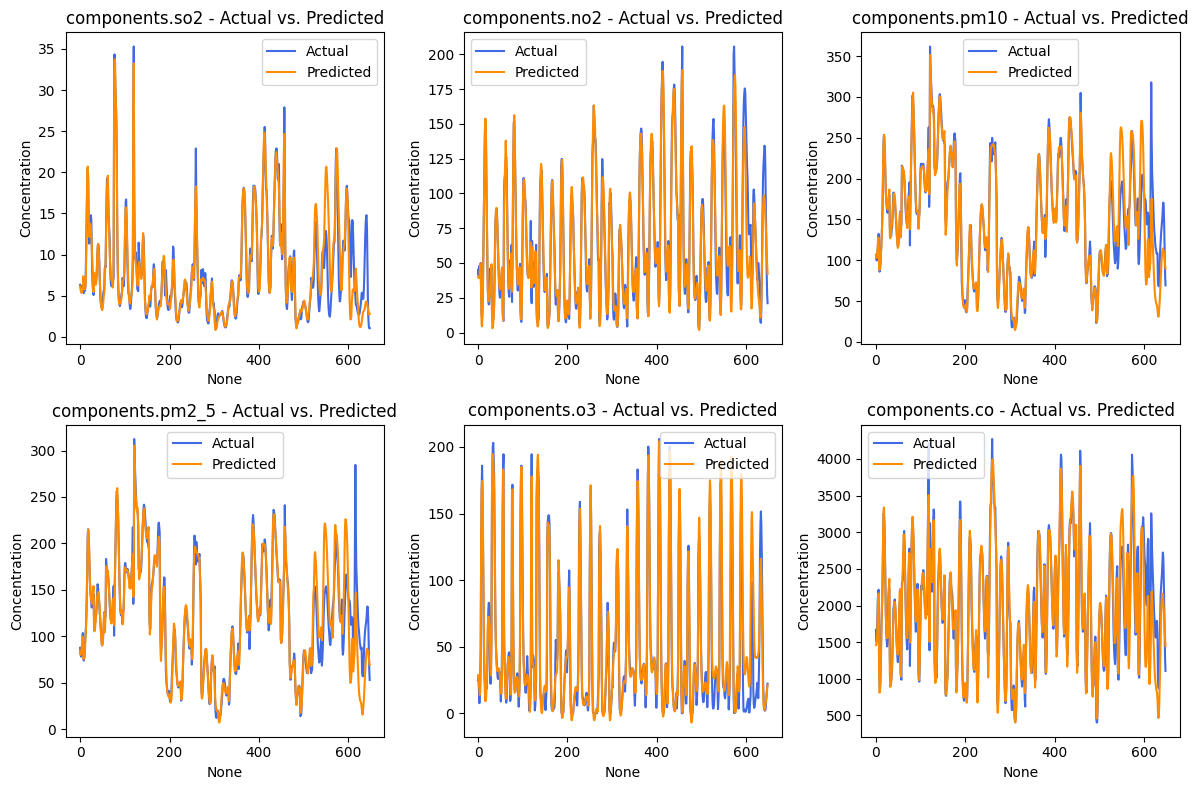

In [28]:
# Test the model using visualization
# Inverse transform the scaled data
y_scaled_inv = target_scaler.inverse_transform(y_scaled)
# Make predictions on the scaled data
y_pred_scaled = best_model.predict(X_scaled)
y_pred_scaled_inv = target_scaler.inverse_transform(y_pred_scaled)

# Create a DataFrame for the actual and predicted values
results_dict = {f'{target}_actual': y_scaled_inv[:, i] for i, target in enumerate(TARGETS)}
results_dict.update({f'{target}_predicted': y_pred_scaled_inv[:, i] for i, target in enumerate(TARGETS)})
results_df = pd.DataFrame(results_dict)

# Plot the actual and predicted values
plt.figure(figsize=(12, 8))
for i, target in enumerate(TARGETS):
    plt.subplot(2, 3, i+1)
    sns.lineplot(x=results_df.index, y=f'{target}_actual', data=results_df, label='Actual', color='royalblue')
    sns.lineplot(x=results_df.index, y=f'{target}_predicted', data=results_df, label='Predicted', color='darkorange')
    plt.title(f'{target} - Actual vs. Predicted')
    plt.ylabel('Concentration')
    plt.legend()
plt.tight_layout()
plt.show()


In [29]:
# Print R2 score for each target
from sklearn.metrics import r2_score

for i, target in enumerate(TARGETS):
    r2 = r2_score(y_scaled_inv[:, i], y_pred_scaled_inv[:, i])
    print(f"Pollutant {target} - R2 Score: {r2:.4f}")


Pollutant components.so2 - R2 Score: 0.8514
Pollutant components.no2 - R2 Score: 0.9396
Pollutant components.pm10 - R2 Score: 0.8943
Pollutant components.pm2_5 - R2 Score: 0.8798
Pollutant components.o3 - R2 Score: 0.9392
Pollutant components.co - R2 Score: 0.8956


In [30]:
from mlflow.tracking import MlflowClient

client = MlflowClient()

# Register the model
model_name = "PollutionTrendPredictionLSTM"
model_uri = f"runs:/{best_run_id}/model"
model_details = client.create_registered_model(model_name)

# Create a new version in the Model Registry
model_version = client.create_model_version(
    name=model_name,
    source=model_uri,
    run_id=best_run_id
)

print(f"Model registered: {model_version.name} version {model_version.version}")


Model registered: PollutionTrendPredictionLSTM version 1


In [31]:
# Transition the model version to 'Production'
client.transition_model_version_stage(
    name=model_name,
    version=model_version.version,
    stage="Production",
    archive_existing_versions=True
)

print(f"Model version {model_version.version} promoted to Production.")


Model version 1 promoted to Production.


C:\Users\Anas\AppData\Local\Temp\ipykernel_10548\2701505284.py:2: FutureWarning: ``mlflow.tracking.client.MlflowClient.transition_model_version_stage`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/latest/model-registry.html#migrating-from-stages
  client.transition_model_version_stage(
